### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial u}{\partial t} - 0.0001 \nabla  u + \nabla \cdot (w u)=0 \text{en} \  M=\Omega \times (0,T) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega = {x \in \mathbb{R}^2 : x_i \in (-0.5,0.5), i=1,2 }$$
$$ w(x_1,X_2) = [-4x_2,4x_1] $$
Y
$$T= \frac{\pi}{2}$$

tenemos que la solución analitica del problema esta dada por la función: 

$$
u(x,t)=\frac{1.0}{1.0+0.1t}exp(-\frac{(\bar{x_1}+0.25)^2+ \bar{x_2}^2}{0.004})
$$

donde: 
$$
\bar{x_1}=x_1cos(4t)+x_2sin(4t) 
$$
$$
\bar{x_2}=-x_1 sin(4t)+x_2cos(4t) 
$$
Primero creamos una malla:

$$
\int_{\Omega} \frac{\partial(u)}{\partial(t)} *v +0.0001{\nabla(u) \cdot \nabla(v)}+\nabla \cdot (w*u)vdx = 0
$$

In [ ]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
import cupy
import cupyx
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import cupyx.scipy.sparse.linalg as linalge
start = time.time()
flag ="R"
parameters['linear_algebra_backend'] = 'Eigen'
def tran2SparseMatrix(A):
    row, col, val = as_backend_type(A).data()
    return sps.csr_matrix((val, col, row))
mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 200# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny = 120# Número de divisiones en x e y
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny,"crossed")  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',1)


w =Expression(('-4*x[1]','4*x[0]'),degree=2)
w = interpolate(w,V_vec)
# Definición de la condición de frontera
u_o = Expression('exp(-(pow(x[0]+0.25,2)+pow(x[1],2))/(0.004))',
                 degree=2)  # Expresión para u_D

u_analytical=Expression('(1.0/(1.0+0.1*t))*exp(-(pow(x[0]*cos(4*t)+x[1]*sin(4*t)+0.25,2)+pow(-x[0]*sin(4*t)+x[1]*cos(4*t),2))/(0.004*(1+0.1*t)))',t=0,degree=1)
class MyExpression0(UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self._t=t
    def eval(self, value, x,):
        x1_bar = x[0]*cos(4*self._t)+x[1]*sin(4*self._t)
        x2_bar = -x[0]*sin(4*self._t)+x[1]*cos(4*self._t)
        value[0] = (1.0/(1.0+0.1*self._t))*exp(-(pow(x1_bar+0.25,2)+pow(x2_bar,2))/(0.004*(1+0.1*self._t)))


def boundary(x, on_boundary):
    return on_boundary  # Función que define la frontera

bc = DirichletBC(V, 0.0 , boundary)  # Aplica la condición de frontera de Dirichlet

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test




K_fem =0.0001*dot(grad(u), grad(v))*dx +div(w*u)*v*dx  # Formulación débil
C_fem=u*v*dx

# algoritmo de arnoldi 
def arnoldi_iteration_3(A, b, n):
    m = A.shape[0]

    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))

    q = b / np.linalg.norm(b)
    Q[:, 0] = q

    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h[0:n, 0:n]

# proceso 
vtkfile_u = XDMFFile("results/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t= 0
u_=Function(V)


K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
#bc.apply(K)
K_=scipy.sparse.csr_matrix(K.array().astype(np.float32)) 
C=assemble(C_fem)
N_degree=C.array().shape[0]
#C_c = tran2SparseMatrix(C)
#C_c = cupyx.scipy.sparse.csr_matrix(C_c)
#bc.apply(C)


#I_np=np.identity(N_degree)
#I_cupy=cupyx.scipy.sparse.identity(N_degree)
# A1 = assemble(L)
# [bc.apply(A1) for bc in bcs]


# b1 = assemble(R)
# [bc.apply(b1) for bc in bcs]
# b1= b1[:]
# b1 = cupy.array(b1)
# X_w.vector()[:] = cupy.asnumpy(linalge.spsolve(A1, b1))
    
C=scipy.sparse.csc_matrix(C.array().astype(np.float32))
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))

# A=-C_1.dot(K_)


start=time.time()
C_1=scipy.sparse.linalg.spsolve(C,I_n)
#C_1=np.linalg.solve(C.array(),I_np)
#C_1 = cupyx.scipy.sparse.linalg.spsolve(C_c, I_cupy)
end = time.time()
print(f"time inv ={end-start}")


u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
m=15
v_hat=np.zeros(m)
v_hat[0]=1

# for n in range(num_steps):
#     t += dt
    
    
#     print(f'step:{n} of {num_steps} time= {t}')
    
#     Beta=np.linalg.norm(u_i)
#     V_m,H_m = arnoldi_iteration_3(A,u_i,m)
#     u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
#     #u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
#     u_.vector()[:]=u_i
    
#     print(Beta)
#     u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)


In [6]:
I_cupy

In [2]:
vtkfile_u = XDMFFile("results/u_analitical.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t=0
for n in range(num_steps):
    t += dt
    u_analytical.t=t
    u_ana = project(u_analytical,V)
    u_ana.rename("u_a", "u_a");vtkfile_u.write(u_ana, t)
    Beta=np.linalg.norm(u_ana.vector().get_local())
    print(Beta)

10.085024586935628
10.081069642749458
10.07711934783074
10.073173693077466
10.069232669412555
10.065296267783763
10.061364479163602
10.057437294549255
10.053514704962469
10.049596701449492
10.045683275080988
10.041774416951924
10.037870118181518
10.033970369913133
10.0300751633142
10.026184489576133
10.022298339914247
10.018416705567672
10.014539577799269
10.010666947895558
10.006798807166616
10.002935146946013
9.999075958590723
9.99522123348104
9.991370963020511
9.98752513863583
9.98368375177679
9.979846793916172
9.976014256549687
9.972186131195894
9.9683624093961
9.964543082714322
9.96072814273716
9.956917581073764
9.953111389355735
9.949309559237035
9.945512082393936
9.941718950524933
9.937930155350662
9.934145688613834
9.930365542079148
9.926589707533228
9.922818176784538
9.919050941663317
9.915287994021492
9.911529325732621
9.9077749286918
9.904024794815603
9.900278916042009
9.89653728433032
9.892799891661094
9.889066730036074
9.885337791478115
9.881613068031115
9.877892551759931


In [20]:
u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
K_=K.array()
C=assemble(C_fem)
C_1=np.linalg.inv(C.array())
A=C_1*K_

In [11]:
V_m.shape

(41, 8)

In [12]:
H_m.shape

(8, 8)

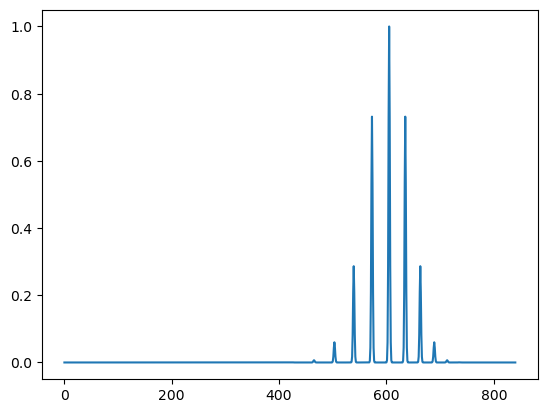

In [13]:
plt.plot(u_i)

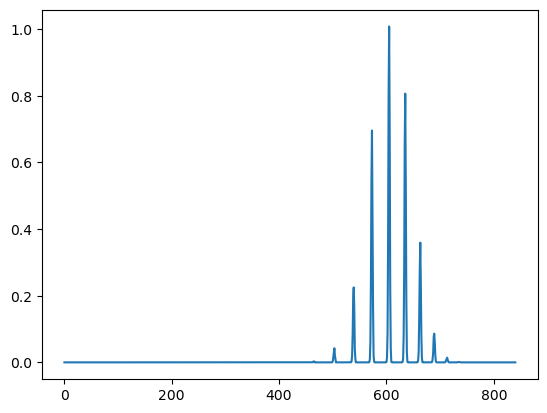

In [51]:
v_hat=np.array([1,0,0,0,0,0,0])
Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,7)
u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
plt.plot(u_i)

In [54]:

Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,8)
np.dot(np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),V_m.T),u_i)

NameError: name 'arnoldi_iteration' is not defined

In [16]:
u.vector()[:]=np.dot(scipy.linalg.expm(0.0001*A),u_i)

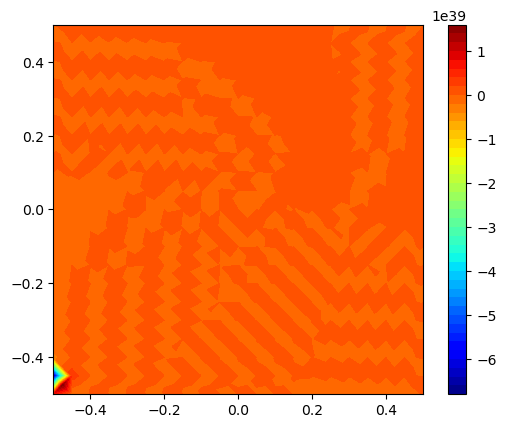

In [17]:

p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

In [45]:
u[1,:].shape

(51521,)

In [3]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 200# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny = 20# Número de divisiones en x e y
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny,"crossed")  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',1)


w =Expression(('-4*x[1]','4*x[0]'),degree=2)
w = interpolate(w,V_vec)
# Definición de la condición de frontera
u_o = Expression('exp(-(pow(x[0]+0.25,2)+pow(x[1],2))/(0.004))',
                 degree=2)  # Expresión para u_D

u_analytical=Expression('(1.0/(1.0+0.1*t))*exp(-(pow(x[0]*cos(4*t)+x[1]*sin(4*t)+0.25,2)+pow(-x[0]*sin(4*t)+x[1]*cos(4*t),2))/(0.004*(1+0.1*t)))',t=0,degree=1)
class MyExpression0(UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self._t=t
    def eval(self, value, x,):
        x1_bar = x[0]*cos(4*self._t)+x[1]*sin(4*self._t)
        x2_bar = -x[0]*sin(4*self._t)+x[1]*cos(4*self._t)
        value[0] = (1.0/(1.0+0.1*self._t))*exp(-(pow(x1_bar+0.25,2)+pow(x2_bar,2))/(0.004*(1+0.1*self._t)))


def boundary(x, on_boundary):
    return on_boundary  # Función que define la frontera

bc = DirichletBC(V, 0.0 , boundary)  # Aplica la condición de frontera de Dirichlet

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test

# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0
u_=Function(V)
vtkfile_ubdf = XDMFFile("results/u_BDF.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False
F = du_t*v*dx + dt*0.0001*dot(grad(u), grad(v))*dx +dt*(div(w*u))*v*dx  # Formulación débil
a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
for n in range(num_steps):

    # Actualizar el tiempo actual
    t += dt
    # Resolver la solución
    solve(a == L, u_)
    # Graficar la solución
    print(f'step:{n} of {num_steps}')
    Beta=np.linalg.norm(u_.vector().get_local())
    print(Beta)
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
    if n%1==0:
        u_n.rename("u_a", "u_a");vtkfile_ubdf.write(u_n, t)
    



Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
step:0 of 200Solving linear variational problem.

2.236513887546452
step:1 of 200
Solving linear variational problem.
2.233209910534238
step:2 of 200
Solving linear variational problem.
2.235317399027806
step:3 of 200
2.238598212551814
step:4 of 200
Solving linear variational problem.
Solving linear variational problem.
2.239790583734526
step:5 of 200
2.2387685306504745
step:6 of 200
Solving linear variational problem.
Solving linear variational problem.
2.236896598509794
step:7 of 200
Solving linear variational problem.
2.2355547817714125
step:8 of 200
2.2355293345640552
Solving linear variational problem.
step:9 of 200
2.2369137884164205
step:10 of 200
2.2392762816032317
step:11 of 200
2.2419663947119606
step:12 of 200
2.244421283016892
step:13 of 200
2.2463432885190153
step:14 of 200
2.2477059249100275
step:15 of 200
2.248640107403726
step:16 of 200
2.2

roblem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear varia

In [1]:
p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

NameError: name 'plot' is not defined